In [27]:
import climetlab as cml
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import num2date, date2num, DateFormatter

In [37]:
# some helper functions

def get_data(df, finit):
    Fi1 = df[df.forecast_reference_time == finit] 
    Fi1_g = Fi1.groupby("time")
    Fi1_g.groups.keys()
    Fi1vals = []
    for t in Fi1.time.unique():
        vnew = Fi1.loc[Fi1_g.groups[t]]["dis24"].values
        Fi1vals.append(vnew)
    Fi1vals = np.stack(Fi1vals).T
    xpositions = [date2num(datetime.datetime.strptime(t, "%Y-%m-%d")) for t in Fi1.time.unique()]
    return Fi1vals, xpositions 


def plot(wb, seas, clims = [], leadtimes = None, finits = [],t_range = ["2022-01-01","2022-12-31"]):

    fig, axs = plt.subplots(len(finits),1,figsize=(15,20), sharex=True, tight_layout=True)

    flierprops = dict(marker='o', markersize=2, linestyle='none')
    medianprops = dict(color="red",linewidth=1)
    boxprops = dict(color="black",linewidth=1)
    
    cmeanvals,cmaxvals,cminvals = clims
    
    timevals = pd.date_range(*t_range,freq="D")
    

    for i, f in enumerate(finits):
        fivals, xpositions = get_data(seas, f)
        axs[i].fill_between(timevals,cmeanvals,cmaxvals,color="blue",alpha=0.2)
        axs[i].fill_between(timevals,cminvals,cmeanvals,color="red",alpha=0.2)
        axs[i].plot(timevals,cmeanvals, linewidth=1, color="black",label = "climatology 2000-2021", alpha=0.5)
        axs[i].boxplot(fivals, positions=xpositions, widths=1.5, 
                       boxprops=boxprops,
                       flierprops=flierprops,
                       medianprops=medianprops, 
                       labels=leadtimes[:fivals.shape[1]]);
        axs[i].scatter(wt, wb.dis24, s=0.5, c="black")
        axs[i].set_xlim([wt[0], wt[-1]])
        axs[i].set_yscale("log")

        axs[i].set_xticks(x_date)
        axs[i].set_xticklabels(x_date.values, fontsize=10)
        axs[i].xaxis.set_major_formatter(DateFormatter("%b"))

    fig.suptitle("2022 - Pontelagoscuro seasonal forecasts")
    fig.supylabel("Discharge m3/s")

# The intense drought on the Po river basin in summer 2022

<p align="center">
 <a href="https://www.greenandblue.it/2022/07/04/news/siccita_po_e_altri_fiumi_da_satellite-356491116/">
<img src="https://github.com/iacopoff/climetlab-cems-flood/blob/main/docs/source/tutorial/img.png?raw=true">
 </a>
</p>

The 2022 drought was one of the worst ever recorder on the Po basin (and not only there). The event was so severe that it was also reported in international newspapers, such as The Guardian: [Quiet flows the Po: the life and slow death of Italy's longest river](https://www.theguardian.com/environment/2022/jul/10/po-river-italy-drought-climate)

## Why?

Because, if you were in the North of Italy, it was a terrible summer!
In 2022 the summer season started with water levels already in deficit due to below average winter and spring precipitation. The situation was alarming, and between one heatwave and the other, I decided to start monitoring the evolution of the water levels on the Po river, as the CDS, the CliMetLab API and this plugin make it quite easy to retrieve data not only for this kind of hobbistic activities, but for proper research and analysis.  </br>

Eventually, at the end of 2022, I pulled together all the seasonal forecast initializations to get a sense of the forecast performance across the year. </br>

## What are we going to see

The GloFAS seasonal forecasts are initializated every beginning of the month, and they provide a 6-month long daily ensembles forecast of river discharge for the entire World (up to a certain latitude). </br>

They may provide valuable information (but check the skill of the forecast at your location) into the upcoming season. </br>

I am going to plot the individual forecast ensembles (12 in total, from January to December 2022), add the 2022 river discharge (water balance) and I am going to overlay some climatological statistics (min, mean, max) for context. This should tell us whether the forecasting system was in agreement with the 'actual' discharge (big disclaimer: the discharge is not from observation, but from reanalysis).

First of all, let's choose the location for this exercise: **Pontelagoscuro** is one of the most downstream river station on the Po river ([Agenzia Po](https://www.agenziapo.it/content/monitoraggio-idrografico-0)), and a good choice to get an overall picture of the Po river flow.

In [10]:
# pontelagoscuro river station
ps = {'name':'pontelagoscuro','lat':44.886111, 'lon':11.604444}

This is the first data retrieval instruction: we are going to need seasonal forecasts for the entire 2022. The arguments of this function are for the most part reflecting the ones from the [CDS download form](https://cds.climate.copernicus.eu/cdsapp#!/dataset/cems-glofas-seasonal?tab=form). The notable differences are the [temporal filter](https://climetlab-cems-flood.readthedocs.io/en/latest/request_options.html#temporal-filtering), the [coords](https://climetlab-cems-flood.readthedocs.io/en/latest/request_options.html#spatial-filtering) and the [split_on](https://climetlab-cems-flood.readthedocs.io/en/latest/request_options.html#speed-up-requests) arguments.

In [13]:
seasonal = cml.load_dataset(
            'cems-glofas-seasonal',
            model='lisflood',
            system_version='operational',
            temporal_filter= '2022 01-12 *',
            leadtime_hour = '24-3600',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps], 
            split_on=["month"],
            threads= 9
);

  0%|          | 0/12 [00:00<?, ?it/s]

We also need the water balance (read: historical discharge)

In [12]:
water_balance = cml.load_dataset(
            'cems-glofas-historical',
            model='lisflood',
            product_type='intermediate',
            system_version='version_3_1',
            temporal_filter= '2022 01-12 *',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps]
        );

And finally we need to retrieve a decent amount of data (~20 years), to get the climatology of the river discharge on that location. See how I have increased the **threads** to speed up the retrieval. In this way you are going to download 21 years concurrently (keep in mind that the CDS is going to **limit** the number of concurrent requests that can be executed at their end, but still.. this is way faster!).

In [14]:
climatology_2000_2021 = cml.load_dataset(
            'cems-glofas-historical',
            model='lisflood',
            product_type='consolidated',
            system_version='version_3_1',
            temporal_filter= '2000-2021 01-12 *',
            variable="river_discharge_in_the_last_24_hours",
            coords=[ps],
            split_on = ['hyear'],
            threads = 21
        );

  0%|          | 0/22 [00:00<?, ?it/s]

Now that we have all the data saved on disk, let's check where the station is located, and if it is in the correct GloFAS grid cells, so that we know we are getting the river discharge timeseries that we wanted.

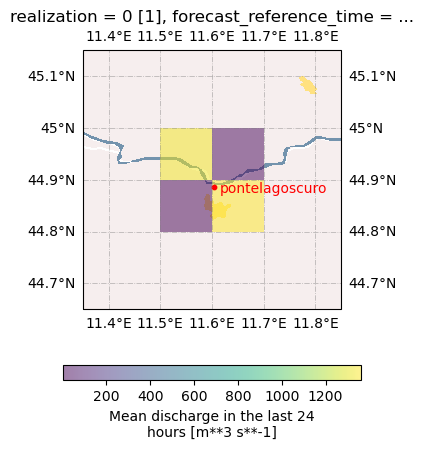

In [6]:
seasonal.show_coords('pontelagoscuro')

All is good. It is exactly where it should be. Note: the 4 pixels are the model grid cells.

Let's read the data in memory, converting it to Xarray Dataset, then compute some statistics for the climatology, and extract the timeseries:

In [28]:
cl = climatology_2000_2021.to_xarray().chunk({"time":500})
seas = seasonal.to_xarray()
wb = water_balance.to_xarray()

# daily climatology
cmean = cl.groupby("time.dayofyear").mean()
cmin = cl.groupby("time.dayofyear").min()
cmax = cl.groupby("time.dayofyear").max()

# drop 29th of February, extract timeseries 
cmax = cmax.where(cmax.dayofyear != cmax.dayofyear[59], drop =True).sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")
cmin = cmin.where(cmin.dayofyear != cmin.dayofyear[59], drop =True).sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")
cmean = cmean.where(cmean.dayofyear != cmean.dayofyear[59], drop =True).sel(latitude=ps['lat'],longitude=ps['lon'],method="nearest")

cmean["time"] =  pd.date_range("2022-01-01","2022-10-31")
cmin["time"]=  pd.date_range("2022-01-01","2022-10-31")
cmax["time"] =  pd.date_range("2022-01-01","2022-10-31")


wb_df = wb.sel(latitude=ps['lat'],longitude=ps['lon'], method="nearest").to_dataframe().reset_index()
wb_df.drop(["latitude", "longitude"], axis=1, inplace=True)
wb_df= wb_df[(wb_df.time.dt.month >= 1) & (wb_df.time.dt.month <= 12) ]
wb_df['time'] =  pd.DatetimeIndex(wb_df.time)

In [31]:
seas_df = seas.sel(lat=ps['lat'],lon=ps['lon'], method="nearest").to_dataframe()
seas_df = seas_df.drop(['lat','lon'], axis=1).reset_index()

# Since I don't want to plot every day of the forecast, filter weekly:
seas_df_w = seas_df[seas_df.time.dt.day.isin([2,9,16,23])]
leadtimes = seas_df_w.leadtime.dt.days.unique()
seas_df_w = seas_df_w.drop(["leadtime"], axis= 1)
seas_df_wf = seas_df_w.loc[(seas_df_w.time.dt.month >= 1) & ( seas_df_w.time.dt.month <= 12)].reset_index(drop=True)
seas_df_wf['time'] = pd.DatetimeIndex(seas_df_wf.time)
seas_df_wf['time'] = seas_df_wf.time.dt.strftime("%Y-%m-%d")

In [34]:
finits = seas_df_wf.forecast_reference_time.dt.strftime("%Y-%m-%d").unique()
wt = [date2num(i) for i in wb_df.time]
x_date = pd.date_range("2022-01-01","2022-12-31",freq="MS")
x_date = pd.to_datetime(x_date,"%Y-%m-%d")
cmeanvals = cmean.dis24.values.T
cmaxvals = cmax.dis24.values.T
cminvals = cmin.dis24.values.T

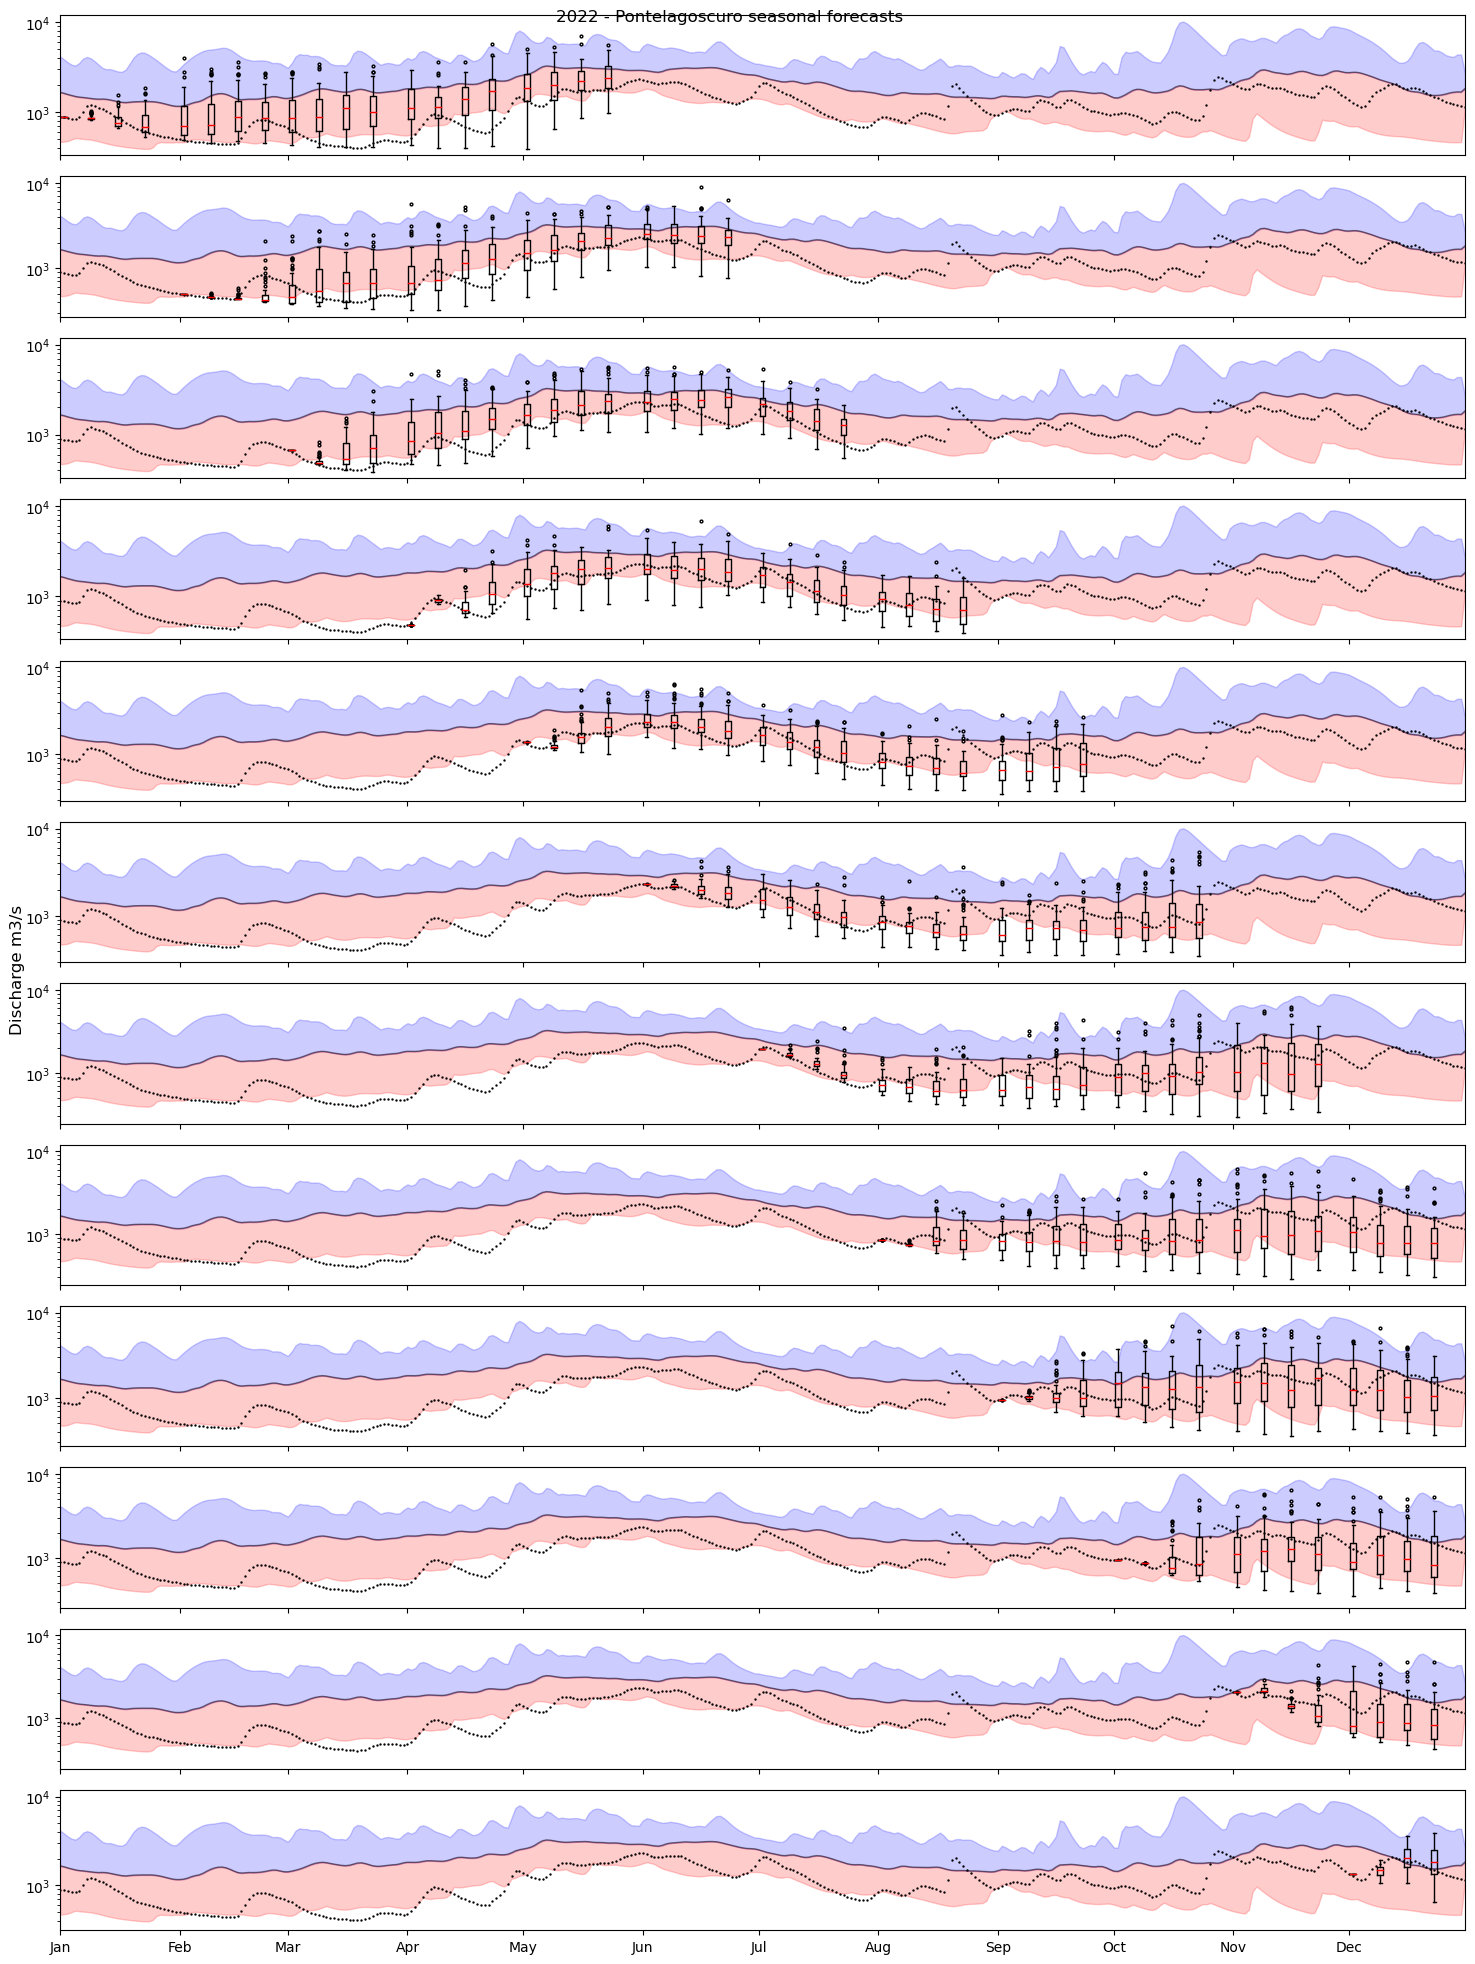

In [38]:
plot(wb_df, seas_df_wf, clims = [cmeanvals,cmaxvals,cminvals], leadtimes = leadtimes, finits = finits, t_range = ["2022-01-01","2022-12-31"])